In [ ]:
#install dependencies
!pip install --upgrade pip
!pip install --quiet --upgrade nltk
!pip install --quiet --upgrade nlpaug
!pip install --quiet --upgrade datasets transformers sentencepiece torch torchvision torchaudio
!pip install --quiet --upgrade scikit-learn
!pip install --quiet --upgrade geomloss
!pip install --quiet --upgrade seaborn matplotlib
!pip install transformers matplotlib seaborn

In [ ]:
#imports
import os
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#patching and pos tagging
from nlpaug.model.word_dict.wordnet import WordNet as NlpaugWordNet

def forced_pos_tag(self, tokens, tagset=None, lang=None):
    """
    Robust POS tagging with enhanced debugging for invalid cases.
    """
    import nltk

    # Tokenize if tokens is a string
    if isinstance(tokens, str):
        tokens = nltk.word_tokenize(tokens)
    elif isinstance(tokens, list):
        tokens = [str(token) for token in tokens]
    else:
        print(f"[WARN] Invalid input to pos_tag: {tokens}")
        return []

    if not tokens:
        print("[WARN] Empty tokens encountered. Skipping...")
        return []

    try:
        return nltk.pos_tag(tokens, tagset=tagset)
    except Exception as e:
        print(f"[ERROR] POS tagging failed. Tokens: {tokens} | Error: {e}")
        return []

NlpaugWordNet.pos_tag = forced_pos_tag

In [ ]:
#rest of imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, roc_auc_score, confusion_matrix
)
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from geomloss import SamplesLoss
import nlpaug.augmenter.word as naw

In [ ]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#load dataset
raw_dataset = load_dataset("bigbio/bionlp_st_2013_ge", "bionlp_st_2013_ge_source")
print(raw_dataset)

train_data = raw_dataset['train']
val_data   = raw_dataset['validation']
test_data  = raw_dataset['test']
full_data  = list(train_data) + list(val_data) + list(test_data)

README.md:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

bionlp_st_2013_ge.py:   0%|          | 0.00/9.50k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/300k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/334k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/344k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/222 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/249 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/305 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'events', 'relations', 'equivalences', 'attributes', 'normalizations'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'events', 'relations', 'equivalences', 'attributes', 'normalizations'],
        num_rows: 249
    })
    test: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'events', 'relations', 'equivalences', 'attributes', 'normalizations'],
        num_rows: 305
    })
})


In [ ]:
#parse
rows = []
for sample in full_data:
    doc_text = sample.get('text', "")
    events = sample.get('events', [])
    if not events or not doc_text.strip():
        continue

    for evt in events:
        evt_type = evt.get('type', "")
        if evt_type == "Phosphorylation":
            action = "Phosphorylation"
        elif evt_type == "Positive_regulation":
            action = "Activation"
        elif evt_type == "Negative_regulation":
            action = "Inhibition"
        else:
            continue

        trigger_info = evt.get('trigger', "")
        trigger_text = (trigger_info.get('text', "").strip() if isinstance(trigger_info, dict)
                        else str(trigger_info).strip())
        if not trigger_text:
            continue

        arguments = evt.get('arguments', [])
        arg_texts = [arg.get('text', "").strip() for arg in arguments if isinstance(arg, dict)]
        entityB = " | ".join(arg_texts) if arg_texts else "None"

        truncated_doc = doc_text[:1500]
        description = f"TRIGGER: {trigger_text} | DOC: {truncated_doc}"

        rows.append({
            "ENTITYA": trigger_text,
            "ENTITYB": entityB,
            "ACTION": action,
            "DESCRIPTION": description,
        })

df = pd.DataFrame(rows).dropna(subset=['DESCRIPTION']).reset_index(drop=True)
print("\nParsed", len(df), "total events.")
print(df['ACTION'].value_counts())




Parsed 3005 total events.
ACTION
Activation         1663
Inhibition         1028
Phosphorylation     314
Name: count, dtype: int64


In [ ]:
#split then augment only train

label_map = {"Inhibition": 0, "Activation": 1, "Phosphorylation": 2}
df['label_idx'] = df['ACTION'].map(label_map)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label_idx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_idx'], random_state=42)

print("\nOriginal Training Size:", len(train_df))
print("Validation Size:", len(val_df))
print("Test Size:", len(test_df))


Original Training Size: 2103
Validation Size: 451
Test Size: 451


In [ ]:
#synonym augmentation
aug = naw.SynonymAug(aug_src='wordnet')

def synonym_augment_data(subdf, label, num_aug=1):
    new_records = []
    for _ in range(num_aug):
        for entA, entB, desc in zip(subdf['ENTITYA'], subdf['ENTITYB'], subdf['DESCRIPTION']):
            combined_str = f"{entA} {entB} {desc}"
            if not combined_str.strip():
                continue
            aug_text = aug.augment(combined_str, n=1)
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            new_records.append({
                "ENTITYA": entA,
                "ENTITYB": entB,
                "ACTION": label,
                "DESCRIPTION": aug_text
            })
    return pd.DataFrame(new_records)

def apply_synonym_augmentation(train_df):
    max_class = train_df['ACTION'].value_counts().max()
    augmented_frames = []
    for label in train_df['ACTION'].unique():
        subdf = train_df[train_df['ACTION'] == label]
        times = max(0, (max_class // len(subdf)) - 1)
        if times > 0:
            aug_df = synonym_augment_data(subdf, label, num_aug=times)
            augmented_frames.append(aug_df)
    if augmented_frames:
        train_df = pd.concat([train_df] + augmented_frames, ignore_index=True)
    return train_df

train_df = apply_synonym_augmentation(train_df)
print("\nAfter Synonym Augmentation, Train Size:", len(train_df))

Streaming output truncated to the last 5000 lines.
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

[ERROR] POS tagging failed. Tokens: ['T74', 'None', 'TRIGGER', ':', 'T74', '|', 'DOC', ':', 'NleH1', 'inhibits', 'RPS3', 'phosphorylation', 'in', 'vitro', 'EHEC', 'pathogens', 'are', 'important', 'causative', 'agents', 'of', 'both', 'foodborne', 'disease', 'and', 'pediatric', 'renal', 'failure31', '.', 'EHEC', 'utilize', 'T3SS', 'to', 'inject', 'effector', 'proteins', 'directly', 'into', 'intestinal', 'epithelial', 'cells32', ',', 'a', 'subset', 'of', 'which', 'inhibit', 'NF', '-', 'kappaB', '-', 'dependent', 'innate', 'responses9', ',', '33', '-', '38', '.', 'The', 'E', '.', 'coli', 'O157', ':', 'H7', 'EDL933', 'effector', 'protein', 'NleH1', 'binds', 'to', 'and', 'attenuates', 'RPS3', 'nuclear', 'translocation', ',

In [ ]:
#label encoding and class weighting

train_df['effect_encoded'] = train_df['ACTION'].map(label_map)
val_df['effect_encoded']   = val_df['ACTION'].map(label_map)
test_df['effect_encoded']  = test_df['ACTION'].map(label_map)

unique_labels = ["Inhibition", "Activation", "Phosphorylation"]
num_classes = len(unique_labels)


assert train_df['effect_encoded'].min() >= 0 and train_df['effect_encoded'].max() < num_classes, "Label out of range!"


counts_array = np.array([len(train_df[train_df['effect_encoded'] == i]) for i in range(num_classes)])
print("Class counts:", counts_array)


epsilon = 1e-8
beta = 0.9999
effective_num = 1.0 - np.power(beta, counts_array) + epsilon
weights = (1.0 - beta) / effective_num
weights = weights / np.sum(weights) * num_classes


class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
torch.cuda.synchronize()
print("Class weights:", class_weights)

print("\nTrain Class Distribution:\n", train_df['ACTION'].value_counts())
print("\nVal Class Distribution:\n", val_df['ACTION'].value_counts())
print("\nTest Class Distribution:\n", test_df['ACTION'].value_counts())


Class counts: [ 719 1164 1100]
Class weights: tensor([1.3058, 0.8245, 0.8697], device='cuda:0')

Train Class Distribution:
 ACTION
Activation         1164
Phosphorylation    1100
Inhibition          719
Name: count, dtype: int64

Val Class Distribution:
 ACTION
Activation         250
Inhibition         154
Phosphorylation     47
Name: count, dtype: int64

Test Class Distribution:
 ACTION
Activation         249
Inhibition         155
Phosphorylation     47
Name: count, dtype: int64


In [ ]:
#tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
#define dataset class
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['DESCRIPTION']
        label = row['effect_encoded']
        if not isinstance(text, str):
            text = str(text)
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train_df, tokenizer)
val_dataset   = TextDataset(val_df, tokenizer)
test_dataset  = TextDataset(test_df, tokenizer)

#BATCH SIZE
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#define biobert model with classification head
class ClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.6)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_classes)
        #FREEZE LAYERS
        for param in self.base_model.encoder.layer[:10].parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


classification_model = ClassificationModel(num_classes).to(device)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
#LOSS FUNCTION
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

focal_loss_fn = FocalLoss(alpha=class_weights, gamma=1.5)

sinkhorn_loss_fn = SamplesLoss(
    loss="sinkhorn",
    p=2,
    blur=0.05,
    scaling=0.8,
    debias=False
)

def bubble_wass_loss(logits, labels):
    fl_loss = focal_loss_fn(logits, labels)
    epsilon = 0.1
    n_cls = logits.size(1)

    labels_one_hot = nn.functional.one_hot(labels, num_classes=n_cls).float()
    labels_smooth = labels_one_hot * (1 - epsilon) + (epsilon / n_cls)

    probs = nn.functional.softmax(logits, dim=1)
    B = probs.size(0)

    cost_map = {0: 0.0, 1: 2.0, 2: 3.0}
    support_vals = [cost_map[i] for i in range(n_cls)]
    support = torch.tensor(support_vals, dtype=torch.float32, device=device).unsqueeze(1)
    support_batch = support.unsqueeze(0).expand(B, n_cls, 1).contiguous()

    a = labels_smooth.unsqueeze(-1).contiguous()
    b = probs.unsqueeze(-1).contiguous()

    wass_distance = sinkhorn_loss_fn(support_batch, support_batch, a, b)
    wass_distance = wass_distance.mean()

    total_loss = fl_loss + 1 * wass_distance
    return total_loss

In [ ]:
#optimizer and scheduleroptimizer = torch.optim.AdamW(
optimizer = torch.optim.AdamW(
    classification_model.parameters(), lr=2e-5, weight_decay=1e-3
)
epochs = 10
total_steps = len(train_loader) * epochs

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)

In [ ]:
#train and eval
def train_epoch(model, data_loader, optimizer, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = bubble_wass_loss(logits, labels)

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader):
    model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = bubble_wass_loss(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), f1

In [ ]:
#training loop
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': [],
    'val_f1': []
}

best_val_f1 = 0
num_epochs = 2
epochs_no_improve = 3
patience = 10

classification_model.eval()
train_acc_init, train_loss_init, train_f1_init = eval_model(classification_model, train_loader)
val_acc_init, val_loss_init, val_f1_init = eval_model(classification_model, val_loader)

history['train_acc'].append(train_acc_init.item())
history['train_loss'].append(train_loss_init)
history['val_acc'].append(val_acc_init.item())
history['val_loss'].append(val_loss_init)
history['val_f1'].append(val_f1_init)

print("Initial (Epoch 0) Metrics:")
print(f"Train Accuracy: {train_acc_init:.4f}, Train Loss: {train_loss_init:.4f}")
print(f"Val Accuracy:   {val_acc_init:.4f}, Val Loss: {val_loss_init:.4f}, Val F1: {val_f1_init:.4f}")

for epoch in range(1, num_epochs + 1):
    classification_model.train()
    train_loss_sum = 0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = classification_model(inputs, attention_mask)
        loss = bubble_wass_loss(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(classification_model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    avg_train_loss = train_loss_sum / len(train_loader)

    classification_model.eval()
    val_loss_sum = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = classification_model(inputs, attention_mask)
            loss = bubble_wass_loss(outputs, labels)
            val_loss_sum += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    validation_accuracy = correct / total
    avg_val_loss = val_loss_sum / len(val_loader)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(avg_train_loss)
    history['val_acc'].append(validation_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)

    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Validation F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(classification_model.state_dict(), 'best_model_state.bin')
    else:
        epochs_no_improve += 1
        if patience and epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

classification_model.load_state_dict(torch.load('best_model_state.bin'))

Initial (Epoch 0) Metrics:
Train Accuracy: 0.3490, Train Loss: 92.4962
Val Accuracy:   0.4967, Val Loss: 92.2137, Val F1: 0.4038

Epoch 1/2
Train Loss: 92.3142, Train Accuracy: 0.4019
Validation Loss: 92.2035, Validation Accuracy: 0.5100, Validation F1: 0.4477

Epoch 2/2
Train Loss: 91.5267, Train Accuracy: 0.5883
Validation Loss: 91.5030, Validation Accuracy: 0.5765, Validation F1: 0.5663


<All keys matched successfully>


Classification Report (Test Set):
                 precision    recall  f1-score   support

     Inhibition       0.56      0.41      0.47       155
     Activation       0.66      0.72      0.69       249
Phosphorylation       0.37      0.51      0.43        47

       accuracy                           0.59       451
      macro avg       0.53      0.55      0.53       451
   weighted avg       0.59      0.59      0.58       451

F1 Score: 0.5849
Precision: 0.5921
Recall: 0.5898
AUC: 0.6814


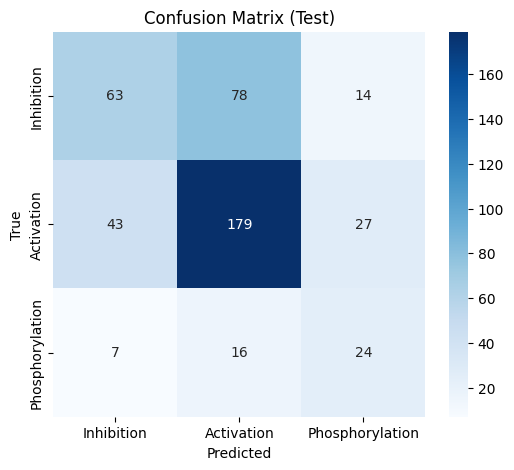

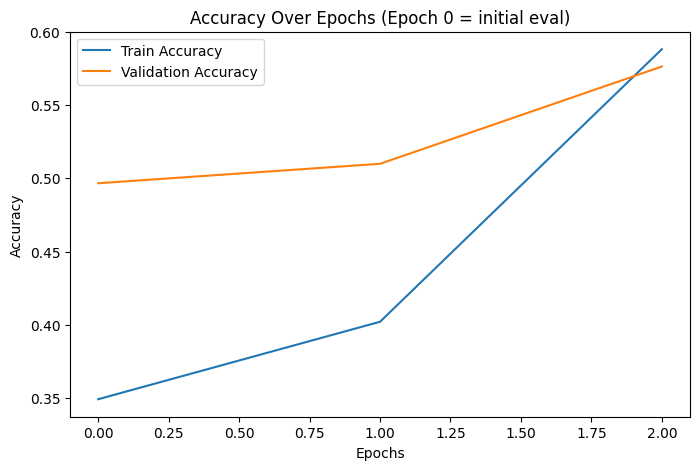

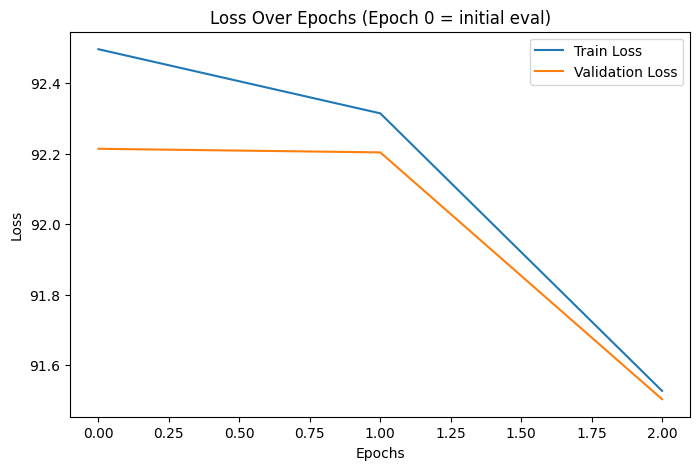

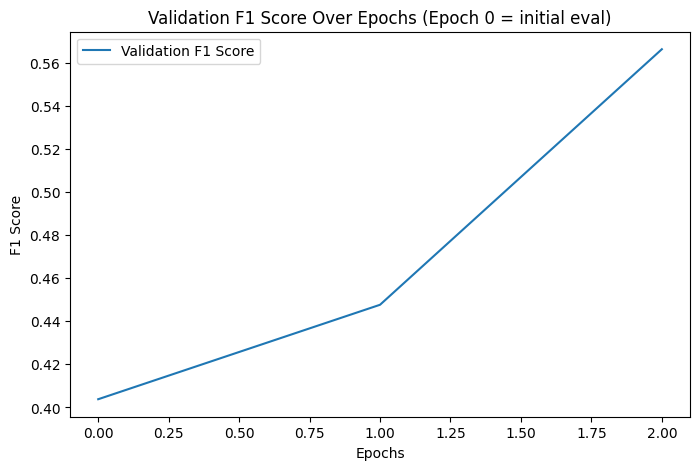


Final Training Distribution:
 ACTION
Activation         1164
Phosphorylation    1100
Inhibition          719
Name: count, dtype: int64


In [ ]:
#val and plot
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = classification_model(input_ids, attention_mask)
        probs = nn.functional.softmax(logits, dim=1)
        _, preds = torch.max(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=unique_labels))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_binarized = label_binarize(y_true, classes=range(num_classes))
y_probs = np.array(y_probs)
if num_classes > 2:
    auc = roc_auc_score(y_test_binarized, y_probs, average='weighted', multi_class='ovr')
else:
    auc = roc_auc_score(y_test_binarized.ravel(), y_probs[:, 1].ravel())
print(f"AUC: {auc:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs (Epoch 0 = initial eval)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (Epoch 0 = initial eval)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('Validation F1 Score Over Epochs (Epoch 0 = initial eval)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

print("\nFinal Training Distribution:\n", train_df['ACTION'].value_counts())
